In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from lightning import pytorch as pl
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from chemprop import data, featurizers, models, nn, utils
from sklearn.model_selection import KFold, train_test_split, GroupKFold
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from lightning.pytorch.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from openpyxl import Workbook
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os
from pathlib import Path
import sys
print('Python:',sys.version)

Python: 3.11.10 (main, Oct  3 2024, 07:29:13) [GCC 11.2.0]


# Full dataset

In [49]:
#D-MPNN with thermodynamic properties

In [2]:
df = pd.read_excel("scCO2_all_data(curated).xlsx")

In [3]:
df_rem = df[~df['Name'].isin(['Water', 'Iodine'])] #remove water and iodine from the data set

In [4]:
smiles_column = ['SMILES_Canonical']
target_columns = ['Lg(y)']
descriptor_columns = ['T (K)', 'P (bar)', 'Melting Point', 'dHvap (kJ/mol)', 'g (gcm3)', 'dG', 'MolWt', 'MolLogP', 'TPSA', 'NR', 'Bj', 'HA', 'HD', 'RC', 'SP', 'NA', 'NAr', 'Hat']

In [5]:
smis = df_rem.loc[:, smiles_column].values.flatten().astype(str)
ys = df_rem.loc[:, target_columns].values
extra_datapoint_descriptors = df_rem[descriptor_columns].values

In [6]:
all_data = [
    data.MoleculeDatapoint(Chem.MolFromSmiles(smi), y, x_d=X_d)
    for smi, y, X_d in zip(smis, ys, extra_datapoint_descriptors)
]

In [7]:
mols = [d.mol for d in all_data]

In [8]:
#Strict split SMILES. D-MPNN with thermodynamic properties

In [9]:
class ScaffoldGroupKFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        unique_groups = np.unique(groups)
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(unique_groups)
        
        fold_size = len(unique_groups) // self.n_splits
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                test_groups = unique_groups[i * fold_size:]
            else:
                test_groups = unique_groups[i * fold_size: (i + 1) * fold_size]
            
            test_indices = np.where(np.isin(groups, test_groups))[0]
            train_indices = np.where(~np.isin(groups, test_groups))[0]
            
            yield train_indices, test_indices

In [10]:
k_splits = ScaffoldGroupKFold(n_splits=5, shuffle=True, random_state=4321)
output_path = Path.cwd() / "hup" / "crossval_results_scCO2.xlsx"

In [11]:
def calculate_aard(true_values, predicted_values):
    true_values = np.array(true_values)  
    predicted_values = np.array(predicted_values)
    return 100 * np.mean(np.abs((true_values - predicted_values) / true_values))

def calculate_r2(true_values, predicted_values):
    true_values = np.array(true_values)  
    predicted_values = np.array(predicted_values)
    return r2_score(true_values, predicted_values)

def calculate_rmse(true_values, predicted_values):
    return np.sqrt(mean_squared_error(true_values, predicted_values))

def calculate_mae(true_values, predicted_values):
    return mean_absolute_error(true_values, predicted_values)

In [15]:
fold_results = {"RMSE": [], "MAE": [], "R²": [], "AARD": []}
all_test_smiles = []
all_test_targets = []
all_test_predictions = []
all_indices = [] 

with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    pd.DataFrame({"Placeholder": []}).to_excel(writer, sheet_name="Init", index=False)

    for fold_idx, (train_indices, test_indices) in enumerate(k_splits.split(mols, groups=df_rem['SMILES_Canonical'])):
        print(f"Starting fold {fold_idx + 1}/5")

        train_data, _, test_data = data.split_data_by_indices(all_data, [train_indices], None, [test_indices])
        train_data, val_data = train_test_split(train_data[0], test_size=0.05, random_state=fold_idx)

        featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
        train_dset = data.MoleculeDataset(train_data, featurizer)
        scaler = train_dset.normalize_targets()

        val_dset = data.MoleculeDataset(val_data, featurizer)
        val_dset.normalize_targets(scaler)

        test_dset = data.MoleculeDataset(test_data[0], featurizer)
        
        targets_scaler = train_dset.normalize_targets()
        extra_datapoint_descriptors_scaler = train_dset.normalize_inputs("X_d")
        val_dset.normalize_targets(targets_scaler)
        val_dset.normalize_inputs("X_d", extra_datapoint_descriptors_scaler)
        
        train_dset.cache = True
        val_dset.cache = True

        train_loader = data.build_dataloader(train_dset, shuffle=True)
        val_loader = data.build_dataloader(val_dset, shuffle=False)
        test_loader = data.build_dataloader(test_dset, shuffle=False)

        # optimized by Ray Tune
        ffn_hidden_dim = 2400
        message_hidden_dim = 300
        depth = 2
        ffn_num_layers = 1
        batch_norm = True
        metric_list = [nn.metrics.RMSE(), nn.metrics.MAE()]
        descriptor_columns = extra_datapoint_descriptors.shape[1]

        mp = nn.BondMessagePassing(d_h=message_hidden_dim)
        agg = nn.MeanAggregation()
        output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
        ffn = nn.RegressionFFN(
            output_transform=output_transform,
            input_dim=message_hidden_dim + descriptor_columns,
            hidden_dim=ffn_hidden_dim,
            n_layers=ffn_num_layers
        )
        X_d_transform = nn.ScaleTransform.from_standard_scaler(extra_datapoint_descriptors_scaler)

        model = models.MPNN(
            mp, agg, ffn, batch_norm, metric_list, X_d_transform=X_d_transform
        )
        
        # Checkpointing
        checkpoint_dir = Path(f"/home/lab101/temp/mdm/bot/chek/fold_{fold_idx}")
        checkpoint_dir.mkdir(parents=True, exist_ok=True)

        checkpointing = ModelCheckpoint(
            dirpath=checkpoint_dir,
            filename="best-{epoch}-{val_loss:.2f}",
            monitor="val_loss",
            mode="min",
            save_weights_only=True
        )

        trainer = pl.Trainer(accelerator="auto", devices=1, max_epochs=15, callbacks=[checkpointing])
        trainer.fit(model, train_loader, val_loader)

        predictions = trainer.predict(model, test_loader)
        test_smiles = [Chem.MolToSmiles(d.mol) for d in test_data[0]]
        test_targets = [d.y[0] for d in test_data[0]]
        fold_predictions = np.concatenate(predictions).flatten().tolist()

        
        fold_indices = df_rem.loc[df_rem.index[test_indices], "index"].dropna().values  # Убираем пропуски
        all_indices.extend(fold_indices)

        all_test_smiles.extend(test_smiles)
        all_test_targets.extend(test_targets)
        all_test_predictions.extend(fold_predictions)

        rmse = calculate_rmse(test_targets, fold_predictions)
        mae = calculate_mae(test_targets, fold_predictions)
        r2 = r2_score(test_targets, fold_predictions)
        aard = calculate_aard(test_targets, fold_predictions)

        fold_results["RMSE"].append(rmse)
        fold_results["MAE"].append(mae)
        fold_results["R²"].append(r2)
        fold_results["AARD"].append(aard)

        df_fold = pd.DataFrame({
            "index": fold_indices,
            "SMILES": test_smiles,
            "True_Target": test_targets,
            "Predicted_Target": fold_predictions
        })
        df_fold.to_excel(writer, sheet_name=f"Fold_{fold_idx + 1}", index=False)

        print(f"Fold {fold_idx + 1}:")
        print(f"  RMSE: {rmse}")
        print(f"  MAE: {mae}")
        print(f"  R²: {r2}")
        print(f"  AARD, %: {aard}")

mean_rmse = np.mean(fold_results["RMSE"])
std_rmse = np.std(fold_results["RMSE"])
mean_mae = np.mean(fold_results["MAE"])
std_mae = np.std(fold_results["MAE"])
mean_r2 = np.mean(fold_results["R²"])
std_r2 = np.std(fold_results["R²"])
mean_aard = np.mean(fold_results["AARD"])
std_aard = np.std(fold_results["AARD"])

print("\nFinal cross-validation results:")
print(f"  RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"  MAE: {mean_mae:.4f} ± {std_mae:.4f}")
print(f"  R²: {mean_r2:.4f} ± {std_r2:.4f}")
print(f"  AARD, %: {mean_aard:.4f} ± {std_aard:.4f}")

df_results = pd.DataFrame({
    "index": all_indices,  
    "SMILES": all_test_smiles,
    "True_Target": all_test_targets,
    "Predicted_Target": all_test_predictions
})
with pd.ExcelWriter(output_path, engine="openpyxl", mode="a") as writer:
    df_results.to_excel(writer, sheet_name="All_Folds", index=False)

Starting fold 1/5


/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/chemprop/data/dataloader.py:52: UserWarning: Dropping last batch of size 1 to avoid issues with batch normalization (dataset size = 1217, batch_size = 64)
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lab101/temp/mdm/bot/chek/fold_0 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
Loading `train_dataloader` to estimate number of stepping batches.
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

  | Name     

Sanity Checking DataLoader 0:  50%|███████▌       | 1/2 [00:00<00:00, 22.30it/s]

/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Epoch 0: 100%|█| 362/362 [00:27<00:00, 13.00it/s, v_num=541, train_loss_step=0.2
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 19/19 [00:01<00:00, 12.78it/s]
Epoch 1: 100%|█| 362/362 [00:29<00:00, 12.10it/s, v_num=541, train_loss_step=0.2
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 19/19 [00:01<00:00, 13.68it/s]
Epoch 2: 100%|█| 362/362 [00:29<00:00, 12.39it/s, v_num=541, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 19/19 [00:01<00:00, 13.06it/s]
Epoch 3: 100%|█| 362/362 [00:29<00:00, 12.26it/s, v_num=541, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 19/19 [00:01<00:00, 12.75it/s]
Epoch 4: 100%|█| 362/362 [00

Validation DataLoader 0: 100%|██████████████████| 19/19 [00:01<00:00, 12.35it/s]
Epoch 5: 100%|█| 362/362 [00:28<00:00, 12.56it/s, v_num=541, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 19/19 [00:01<00:00, 12.84it/s]
Epoch 6: 100%|█| 362/362 [00:28<00:00, 12.65it/s, v_num=541, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 19/19 [00:01<00:00, 13.64it/s]
Epoch 7: 100%|█| 362/362 [00:28<00:00, 12.92it/s, v_num=541, train_loss_step=0.2
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 19/19 [00:01<00:00, 13.04it/s]
Epoch 8: 100%|█| 362/362 [00:28<00:00, 12.69it/s, v_num=541, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  32

Validation DataLoader 0: 100%|██████████████████| 19/19 [00:01<00:00, 13.06it/s]
Epoch 9: 100%|█| 362/362 [00:28<00:00, 12.62it/s, v_num=541, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 19/19 [00:01<00:00, 11.93it/s]
Epoch 10: 100%|█| 362/362 [00:29<00:00, 12.32it/s, v_num=541, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 19/19 [00:01<00:00, 12.01it/s]
Epoch 11: 100%|█| 362/362 [00:28<00:00, 12.54it/s, v_num=541, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 19/19 [00:01<00:00, 13.55it/s]
Epoch 12: 100%|█| 362/362 [00:29<00:00, 12.44it/s, v_num=541, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  58

Validation DataLoader 0: 100%|██████████████████| 19/19 [00:01<00:00, 12.94it/s]
Epoch 13: 100%|█| 362/362 [00:29<00:00, 12.46it/s, v_num=541, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 19/19 [00:01<00:00, 13.98it/s]
Epoch 14: 100%|█| 362/362 [00:29<00:00, 12.22it/s, v_num=541, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 19/19 [00:01<00:00, 13.26it/s]
Epoch 14: 100%|█| 362/362 [00:31<00:00, 11.63it/s, v_num=541, train_loss_step=0.

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 362/362 [00:31<00:00, 11.62it/s, v_num=541, train_loss_step=0.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████| 99/99 [00:28<00:00,  3.48it/s]
Fold 1:
  RMSE: 0.735734205521062
  MAE: 0.5220301795565055
  R²: 0.7367235684206928
  AARD, %: 15.912831684482951
Starting fold 2/5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lab101/temp/mdm/bot/chek/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
Loading `train_dataloader` to estimate number of stepping batches.
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | MeanAggregation    | 0      | train
2 | bn    

Sanity Checking:   0%|                                    | 0/2 [00:00<?, ?it/s]

/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Epoch 0: 100%|█| 342/342 [00:28<00:00, 11.87it/s, v_num=542, train_loss_step=0.2
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 18/18 [00:01<00:00, 11.21it/s]
Epoch 1: 100%|█| 342/342 [00:27<00:00, 12.32it/s, v_num=542, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 18/18 [00:01<00:00, 11.70it/s]
Epoch 2: 100%|█| 342/342 [00:28<00:00, 12.09it/s, v_num=542, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 18/18 [00:01<00:00, 11.11it/s]
Epoch 3: 100%|█| 342/342 [00:27<00:00, 12.62it/s, v_num=542, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 18/18 [00:01<00:00, 11.46it/s]
Epoch 4: 100%|█| 342/342 [00

Validation DataLoader 0: 100%|██████████████████| 18/18 [00:01<00:00, 11.84it/s]
Epoch 5: 100%|█| 342/342 [00:27<00:00, 12.45it/s, v_num=542, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 18/18 [00:01<00:00, 14.08it/s]
Epoch 6: 100%|█| 342/342 [00:28<00:00, 11.79it/s, v_num=542, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 18/18 [00:01<00:00, 12.80it/s]
Epoch 7: 100%|█| 342/342 [00:28<00:00, 12.11it/s, v_num=542, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 18/18 [00:01<00:00, 12.42it/s]
Epoch 8: 100%|█| 342/342 [00:28<00:00, 11.93it/s, v_num=542, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:  78

Validation DataLoader 0: 100%|██████████████████| 18/18 [00:01<00:00, 12.74it/s]
Epoch 9: 100%|█| 342/342 [00:27<00:00, 12.44it/s, v_num=542, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 18/18 [00:01<00:00, 12.52it/s]
Epoch 10: 100%|█| 342/342 [00:27<00:00, 12.39it/s, v_num=542, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 18/18 [00:01<00:00, 11.65it/s]
Epoch 11: 100%|█| 342/342 [00:28<00:00, 11.96it/s, v_num=542, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 18/18 [00:01<00:00, 13.41it/s]
Epoch 12: 100%|█| 342/342 [00:28<00:00, 12.19it/s, v_num=542, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100

Validation DataLoader 0: 100%|██████████████████| 18/18 [00:01<00:00, 12.18it/s]
Epoch 14: 100%|█| 342/342 [00:28<00:00, 12.18it/s, v_num=542, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 18/18 [00:01<00:00, 12.23it/s]
Epoch 14: 100%|█| 342/342 [00:29<00:00, 11.55it/s, v_num=542, train_loss_step=0.

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 342/342 [00:29<00:00, 11.53it/s, v_num=542, train_loss_step=0.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|████████████████| 119/119 [00:34<00:00,  3.42it/s]
Fold 2:
  RMSE: 0.7344549390545883
  MAE: 0.518660245265992
  R²: 0.7330662703910096
  AARD, %: 15.123718067640779
Starting fold 3/5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lab101/temp/mdm/bot/chek/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
Loading `train_dataloader` to estimate number of stepping batches.
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | MeanAggregation    | 0      | train
2 | bn    

Sanity Checking DataLoader 0:  50%|███████▌       | 1/2 [00:00<00:00, 15.08it/s]

/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Epoch 0: 100%|█| 372/372 [00:30<00:00, 12.12it/s, v_num=543, train_loss_step=0.7
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 12.00it/s]
Epoch 1: 100%|█| 372/372 [00:30<00:00, 12.29it/s, v_num=543, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 13.74it/s]
Epoch 2: 100%|█| 372/372 [00:30<00:00, 12.22it/s, v_num=543, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 12.17it/s]
Epoch 3: 100%|█| 372/372 [00:30<00:00, 12.24it/s, v_num=543, train_loss_step=0.3
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 12.01it/s]
Epoch 4: 100%|█| 372/372 [00

Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 12.47it/s]
Epoch 5: 100%|█| 372/372 [00:29<00:00, 12.44it/s, v_num=543, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 12.74it/s]
Epoch 6: 100%|█| 372/372 [00:30<00:00, 12.27it/s, v_num=543, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 11.89it/s]
Epoch 7: 100%|█| 372/372 [00:30<00:00, 12.18it/s, v_num=543, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 11.91it/s]
Epoch 8: 100%|█| 372/372 [00:30<00:00, 12.33it/s, v_num=543, train_loss_step=0.0
Validation: |               

Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 13.73it/s]
Epoch 9: 100%|█| 372/372 [00:28<00:00, 13.05it/s, v_num=543, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 11.72it/s]
Epoch 10: 100%|█| 372/372 [00:30<00:00, 12.07it/s, v_num=543, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 12.83it/s]
Epoch 11: 100%|█| 372/372 [00:31<00:00, 11.96it/s, v_num=543, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 12.27it/s]
Epoch 12: 100%|█| 372/372 [00:30<00:00, 12.02it/s, v_num=543, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation:   0%|           

Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 13.58it/s]
Epoch 13: 100%|█| 372/372 [00:30<00:00, 12.32it/s, v_num=543, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 13.04it/s]
Epoch 14: 100%|█| 372/372 [00:30<00:00, 12.01it/s, v_num=543, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 11.66it/s]
Epoch 14: 100%|█| 372/372 [00:32<00:00, 11.34it/s, v_num=543, train_loss_step=0.

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 372/372 [00:32<00:00, 11.34it/s, v_num=543, train_loss_step=0.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████| 88/88 [00:23<00:00,  3.68it/s]
Fold 3:
  RMSE: 0.7814481025906823
  MAE: 0.5904853303339994
  R²: 0.6953131282456122
  AARD, %: 16.473632775758304
Starting fold 4/5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lab101/temp/mdm/bot/chek/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
Loading `train_dataloader` to estimate number of stepping batches.
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | MeanAggregation    | 0      | train
2 | bn    

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Epoch 0: 100%|█| 366/366 [00:32<00:00, 11.20it/s, v_num=544, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 10.23it/s]
Epoch 1: 100%|█| 366/366 [00:32<00:00, 11.09it/s, v_num=544, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 12.87it/s]
Epoch 2: 100%|█| 366/366 [00:30<00:00, 12.16it/s, v_num=544, train_loss_step=0.2
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 13.28it/s]
Epoch 3: 100%|█| 366/366 [00:30<00:00, 11.83it/s, v_num=544, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 11.05it/s]
Epoch 4: 100%|█| 366/366 [00

Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 13.42it/s]
Epoch 5: 100%|█| 366/366 [00:31<00:00, 11.44it/s, v_num=544, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 13.26it/s]
Epoch 6: 100%|█| 366/366 [00:31<00:00, 11.61it/s, v_num=544, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 13.96it/s]
Epoch 7: 100%|█| 366/366 [00:30<00:00, 12.19it/s, v_num=544, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 12.29it/s]
Epoch 8: 100%|█| 366/366 [00:31<00:00, 11.58it/s, v_num=544, train_loss_step=0.0
Validation: |               

Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 11.82it/s]
Epoch 9: 100%|█| 366/366 [00:30<00:00, 11.99it/s, v_num=544, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 11.10it/s]
Epoch 10: 100%|█| 366/366 [00:31<00:00, 11.60it/s, v_num=544, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 12.89it/s]
Epoch 11: 100%|█| 366/366 [00:30<00:00, 11.91it/s, v_num=544, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 11.84it/s]
Epoch 12: 100%|█| 366/366 [00:33<00:00, 10.95it/s, v_num=544, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation:   0%|           

Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 10.81it/s]
Epoch 13: 100%|█| 366/366 [00:31<00:00, 11.75it/s, v_num=544, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 12.24it/s]
Epoch 14: 100%|█| 366/366 [00:30<00:00, 12.06it/s, v_num=544, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 12.77it/s]
Epoch 14: 100%|█| 366/366 [00:32<00:00, 11.43it/s, v_num=544, train_loss_step=0.

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 366/366 [00:32<00:00, 11.42it/s, v_num=544, train_loss_step=0.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████| 94/94 [00:23<00:00,  4.01it/s]
Fold 4:
  RMSE: 0.7335872949038572
  MAE: 0.5242333546898993
  R²: 0.7442214796979189
  AARD, %: 18.159708503266817
Starting fold 5/5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lab101/temp/mdm/bot/chek/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
Loading `train_dataloader` to estimate number of stepping batches.
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | MeanAggregation    | 0      | train
2 | bn    

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Epoch 0: 100%|█| 379/379 [00:30<00:00, 12.41it/s, v_num=545, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 12.23it/s]
Epoch 1: 100%|█| 379/379 [00:32<00:00, 11.81it/s, v_num=545, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 13.54it/s]
Epoch 2: 100%|█| 379/379 [00:30<00:00, 12.51it/s, v_num=545, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 11.55it/s]
Epoch 3: 100%|█| 379/379 [00:30<00:00, 12.31it/s, v_num=545, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 12.30it/s]
Epoch 4: 100%|█| 379/379 [00

Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 13.87it/s]
Epoch 5: 100%|█| 379/379 [00:31<00:00, 12.06it/s, v_num=545, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 10.60it/s]
Epoch 6: 100%|█| 379/379 [00:31<00:00, 12.03it/s, v_num=545, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 12.59it/s]
Epoch 7: 100%|█| 379/379 [00:32<00:00, 11.77it/s, v_num=545, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 11.70it/s]
Epoch 8: 100%|█| 379/379 [00:30<00:00, 12.42it/s, v_num=545, train_loss_step=0.0
Validation: |               

Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 11.67it/s]
Epoch 9: 100%|█| 379/379 [00:30<00:00, 12.53it/s, v_num=545, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 12.21it/s]
Epoch 10: 100%|█| 379/379 [00:31<00:00, 12.00it/s, v_num=545, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 11.04it/s]
Epoch 11: 100%|█| 379/379 [00:30<00:00, 12.31it/s, v_num=545, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 11.36it/s]
Epoch 12: 100%|█| 379/379 [00:31<00:00, 12.10it/s, v_num=545, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation:   0%|           

Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 11.25it/s]
Epoch 13: 100%|█| 379/379 [00:31<00:00, 11.96it/s, v_num=545, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 11.74it/s]
Epoch 14: 100%|█| 379/379 [00:31<00:00, 12.10it/s, v_num=545, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 20/20 [00:01<00:00, 11.97it/s]
Epoch 14: 100%|█| 379/379 [00:33<00:00, 11.44it/s, v_num=545, train_loss_step=0.

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 379/379 [00:33<00:00, 11.43it/s, v_num=545, train_loss_step=0.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████| 80/80 [00:22<00:00,  3.63it/s]
Fold 5:
  RMSE: 0.8377358523307432
  MAE: 0.6492816482377013
  R²: 0.6172746712424727
  AARD, %: 18.892224956817163

Final cross-validation results:
  RMSE: 0.7646 ± 0.0408
  MAE: 0.5609 ± 0.0516
  R²: 0.7053 ± 0.0472
  AARD, %: 16.9124 ± 1.4047


In [16]:
#CatBoost

In [19]:
CDK_desc=pd.read_csv(f"/home/lab101/temp/mdm/DeepChem/Models_scCO2/CO2_CDKdesc_Total.csv")
list_descs = pd.read_csv("CDK_DES.csv")["Name"]
des_cdk = CDK_desc[list_descs].fillna(0)

In [20]:
X=pd.concat([df["T (K)"], df["P (bar)"], df["Melting Point"], df["dHvap (kJ/mol)"], df["g (gcm3)"], df["dG"], des_cdk], axis=1)
y = df["Lg(y)"]

In [22]:
class UniqueGroupKFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        unique_groups = np.unique(groups)
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(unique_groups)
        
        fold_size = len(unique_groups) // self.n_splits
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                test_groups = unique_groups[i * fold_size:]
            else:
                test_groups = unique_groups[i * fold_size: (i + 1) * fold_size]
            
            test_indices = np.where(np.isin(groups, test_groups))[0]
            train_indices = np.where(~np.isin(groups, test_groups))[0]
            
            if len(test_indices) > 0 and len(train_indices) > 0:
                yield train_indices, test_indices

In [23]:
cv = UniqueGroupKFold(n_splits=5, shuffle=True, random_state=4321)

In [33]:
Y_pred, Y_true = [], []
r2_scores, rmse_scores, mae_scores, aards = [], [], [], []
indices, experimental_values, predicted_values = [], [], []

for train_index, test_index in cv.split(X, groups=df['SMILES_Canonical']):
    x_train = X.loc[train_index].values
    x_test = X.loc[test_index].values
    y_train = y[train_index]
    y_test = y[test_index]
    
    cb = CatBoostRegressor(silent=True)
    cb.fit(x_train, y_train)
    y_pred = cb.predict(x_test)
    
    
    Y_pred.extend(y_pred)
    Y_true.extend(y_test)
    indices.extend(df.loc[test_index, "index"].values) 
    experimental_values.extend(y_test)
    predicted_values.extend(y_pred)
    
    
    r2_scores.append(metrics.r2_score(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    
   
    relative_deviation = (y_test - y_pred) / y_test
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean() * 100
    aards.append(average_relative_deviation)


results_df = pd.DataFrame({
    'index': indices,
    'experimental': experimental_values,
    'predicted': predicted_values
})

# Выводим средние значения метрик и их стандартные отклонения
print('R^2 = {} ± {}'.format(round(np.mean(r2_scores), 3), round(np.std(r2_scores), 3)))
print('RMSE = {} ± {}'.format(round(np.mean(rmse_scores), 3), round(np.std(rmse_scores), 3)))
print('MAE = {} ± {}'.format(round(np.mean(mae_scores), 3), round(np.std(mae_scores), 3)))
print('AARD = {} ± {}'.format(round(np.mean(aards), 3), round(np.std(aards), 3)))

/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

R^2 = 0.732 ± 0.028
RMSE = 0.729 ± 0.045
MAE = 0.535 ± 0.02
AARD = 16.353 ± 2.991


In [42]:
consens_df["cons"] = consens_df[["Predicted_Target", "predicted"]].mean(axis=1)

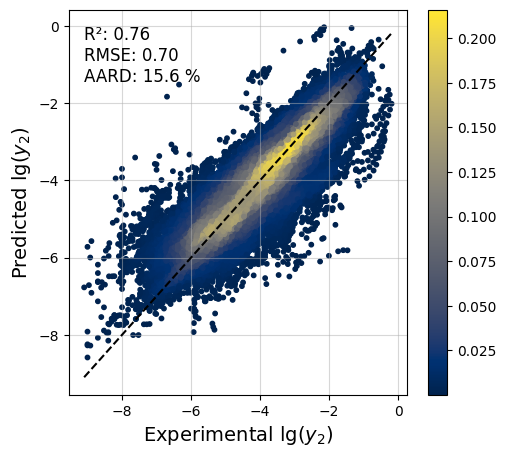

In [48]:
experimental = np.array(consens_df["experimental"])
predicted = np.array(consens_df["cons"])
errors = predicted - experimental

def calculate_aard(experimental, predicted):
    relative_errors = np.abs((experimental - predicted) / experimental)
    aard = np.mean(relative_errors) * 100 
    return aard

def scatter_density_plot(experimental, predicted):
    xy = np.vstack([experimental, predicted])
    z = gaussian_kde(xy)(xy)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    scatter = plt.scatter(experimental, predicted, c=z, s=10, cmap='cividis', alpha=1)
    plt.colorbar(scatter)
     
    plt.plot([min(experimental), max(experimental)], [min(experimental), max(experimental)], 'k--')

    plt.xlabel(r'Experimental $\mathrm{lg}(y_2)$', fontsize=14)
    plt.ylabel(r'Predicted $\mathrm{lg}(y_2)$', fontsize=14)
    plt.grid(True, alpha=0.5)

    rmse = np.sqrt(np.mean(errors**2))
    r_squared = np.corrcoef(experimental, predicted)[0, 1]**2
    aard = calculate_aard(experimental, predicted) 
    
    plt.text(min(experimental), max(predicted) - 1.4, f'R²: {r_squared:.2f}\nRMSE: {rmse:.2f} \nAARD: {aard:.1f} %', fontsize=12)


scatter_density_plot(experimental, predicted)

# Drug-like dataset

In [2]:
df = pd.read_excel("Drug-like_data.xlsx")

In [3]:
smiles_column = ['SMILES_Canonical']
target_columns = ['Lg(y)']
descriptor_columns = ['T (K)', 'P (bar)', 'Melting Point', 'dHvap (kJ/mol)', 'g (gcm3)', 'dG', 'MolWt', 'MolLogP', 'TPSA', 'NR', 'Bj', 'HA', 'HD', 'RC', 'SP', 'NA', 'NAr', 'Hat']

In [4]:
smis = df.loc[:, smiles_column].values.flatten().astype(str)
ys = df.loc[:, target_columns].values
extra_datapoint_descriptors = df[descriptor_columns].values

In [5]:
all_data = [
    data.MoleculeDatapoint(Chem.MolFromSmiles(smi), y, x_d=X_d)
    for smi, y, X_d in zip(smis, ys, extra_datapoint_descriptors)
]

In [6]:
mols = [d.mol for d in all_data]

In [7]:
class ScaffoldGroupKFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        unique_groups = np.unique(groups)
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(unique_groups)
        
        fold_size = len(unique_groups) // self.n_splits
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                test_groups = unique_groups[i * fold_size:]
            else:
                test_groups = unique_groups[i * fold_size: (i + 1) * fold_size]
            
            test_indices = np.where(np.isin(groups, test_groups))[0]
            train_indices = np.where(~np.isin(groups, test_groups))[0]
            
            yield train_indices, test_indices

In [8]:
k_splits = ScaffoldGroupKFold(n_splits=5, shuffle=True, random_state=4321)
output_path = Path.cwd() / "hup" / "crossval_results_scCO2.xlsx"

In [9]:
def calculate_aard(true_values, predicted_values):
    true_values = np.array(true_values)  
    predicted_values = np.array(predicted_values)
    return 100 * np.mean(np.abs((true_values - predicted_values) / true_values))

def calculate_r2(true_values, predicted_values):
    true_values = np.array(true_values)  
    predicted_values = np.array(predicted_values)
    return r2_score(true_values, predicted_values)

def calculate_rmse(true_values, predicted_values):
    return np.sqrt(mean_squared_error(true_values, predicted_values))

def calculate_mae(true_values, predicted_values):
    return mean_absolute_error(true_values, predicted_values)

In [10]:
fold_results = {"RMSE": [], "MAE": [], "R²": [], "AARD": []}
all_test_smiles = []
all_test_targets = []
all_test_predictions = []
all_indices = [] 

with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    pd.DataFrame({"Placeholder": []}).to_excel(writer, sheet_name="Init", index=False)

    for fold_idx, (train_indices, test_indices) in enumerate(k_splits.split(mols, groups=df['SMILES_Canonical'])):
        print(f"Starting fold {fold_idx + 1}/5")

        train_data, _, test_data = data.split_data_by_indices(all_data, [train_indices], None, [test_indices])
        train_data, val_data = train_test_split(train_data[0], test_size=0.05, random_state=fold_idx)

        featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
        train_dset = data.MoleculeDataset(train_data, featurizer)
        scaler = train_dset.normalize_targets()

        val_dset = data.MoleculeDataset(val_data, featurizer)
        val_dset.normalize_targets(scaler)

        test_dset = data.MoleculeDataset(test_data[0], featurizer)
        
        targets_scaler = train_dset.normalize_targets()
        extra_datapoint_descriptors_scaler = train_dset.normalize_inputs("X_d")
        val_dset.normalize_targets(targets_scaler)
        val_dset.normalize_inputs("X_d", extra_datapoint_descriptors_scaler)
        
        train_dset.cache = True
        val_dset.cache = True

        train_loader = data.build_dataloader(train_dset, shuffle=True)
        val_loader = data.build_dataloader(val_dset, shuffle=False)
        test_loader = data.build_dataloader(test_dset, shuffle=False)

        # optimized by Ray Tune
        ffn_hidden_dim = 2400
        message_hidden_dim = 300
        depth = 2
        ffn_num_layers = 1
        batch_norm = True
        metric_list = [nn.metrics.RMSE(), nn.metrics.MAE()]
        descriptor_columns = extra_datapoint_descriptors.shape[1]

        mp = nn.BondMessagePassing(d_h=message_hidden_dim)
        agg = nn.MeanAggregation()
        output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)
        ffn = nn.RegressionFFN(
            output_transform=output_transform,
            input_dim=message_hidden_dim + descriptor_columns,
            hidden_dim=ffn_hidden_dim,
            n_layers=ffn_num_layers
        )
        X_d_transform = nn.ScaleTransform.from_standard_scaler(extra_datapoint_descriptors_scaler)

        model = models.MPNN(
            mp, agg, ffn, batch_norm, metric_list, X_d_transform=X_d_transform
        )
        
        # Checkpointing
        checkpoint_dir = Path(f"/home/lab101/temp/mdm/bot/chek/fold_{fold_idx}")
        checkpoint_dir.mkdir(parents=True, exist_ok=True)

        checkpointing = ModelCheckpoint(
            dirpath=checkpoint_dir,
            filename="best-{epoch}-{val_loss:.2f}",
            monitor="val_loss",
            mode="min",
            save_weights_only=True
        )

        trainer = pl.Trainer(accelerator="auto", devices=1, max_epochs=15, callbacks=[checkpointing])
        trainer.fit(model, train_loader, val_loader)

        predictions = trainer.predict(model, test_loader)
        test_smiles = [Chem.MolToSmiles(d.mol) for d in test_data[0]]
        test_targets = [d.y[0] for d in test_data[0]]
        fold_predictions = np.concatenate(predictions).flatten().tolist()

        
        fold_indices = df.loc[df.index[test_indices], "index2"].dropna().values 
        all_indices.extend(fold_indices)

        all_test_smiles.extend(test_smiles)
        all_test_targets.extend(test_targets)
        all_test_predictions.extend(fold_predictions)

        rmse = calculate_rmse(test_targets, fold_predictions)
        mae = calculate_mae(test_targets, fold_predictions)
        r2 = r2_score(test_targets, fold_predictions)
        aard = calculate_aard(test_targets, fold_predictions)

        fold_results["RMSE"].append(rmse)
        fold_results["MAE"].append(mae)
        fold_results["R²"].append(r2)
        fold_results["AARD"].append(aard)

        df_fold = pd.DataFrame({
            "index2": fold_indices,
            "SMILES": test_smiles,
            "True_Target": test_targets,
            "Predicted_Target": fold_predictions
        })
        df_fold.to_excel(writer, sheet_name=f"Fold_{fold_idx + 1}", index=False)

        print(f"Fold {fold_idx + 1}:")
        print(f"  RMSE: {rmse}")
        print(f"  MAE: {mae}")
        print(f"  R²: {r2}")
        print(f"  AARD, %: {aard}")

mean_rmse = np.mean(fold_results["RMSE"])
std_rmse = np.std(fold_results["RMSE"])
mean_mae = np.mean(fold_results["MAE"])
std_mae = np.std(fold_results["MAE"])
mean_r2 = np.mean(fold_results["R²"])
std_r2 = np.std(fold_results["R²"])
mean_aard = np.mean(fold_results["AARD"])
std_aard = np.std(fold_results["AARD"])

print("\nFinal cross-validation results:")
print(f"  RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
print(f"  MAE: {mean_mae:.4f} ± {std_mae:.4f}")
print(f"  R²: {mean_r2:.4f} ± {std_r2:.4f}")
print(f"  AARD, %: {mean_aard:.4f} ± {std_aard:.4f}")

df_results = pd.DataFrame({
    "index2": all_indices,  
    "SMILES": all_test_smiles,
    "True_Target": all_test_targets,
    "Predicted_Target": all_test_predictions
})
with pd.ExcelWriter(output_path, engine="openpyxl", mode="a") as writer:
    df_results.to_excel(writer, sheet_name="All_Folds", index=False)

Starting fold 1/5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lab101/temp/mdm/bot/chek/fold_0 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
Loading `train_dataloader` to estimate number of stepping batches.
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider in

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Epoch 0: 100%|█| 238/238 [00:15<00:00, 15.18it/s, v_num=551, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 17.67it/s]
Epoch 1: 100%|█| 238/238 [00:13<00:00, 17.16it/s, v_num=551, train_loss_step=0.6
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 18.15it/s]
Epoch 2: 100%|█| 238/238 [00:14<00:00, 16.50it/s, v_num=551, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 20.35it/s]
Epoch 3: 100%|█| 238/238 [00:14<00:00, 16.54it/s, v_num=551, train_loss_step=0.2
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 18.99it/s]
Epoch 4: 100%|█| 238/238 [00

Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 20.30it/s]
Epoch 6: 100%|█| 238/238 [00:13<00:00, 17.12it/s, v_num=551, train_loss_step=0.2
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 19.12it/s]
Epoch 7: 100%|█| 238/238 [00:13<00:00, 17.06it/s, v_num=551, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 19.47it/s]
Epoch 8: 100%|█| 238/238 [00:14<00:00, 16.78it/s, v_num=551, train_loss_step=0.2
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 15.97it/s]
Epoch 9: 100%|█| 238/238 [00:14<00:00, 16.61it/s, v_num=551, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100

Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 19.21it/s]
Epoch 12: 100%|█| 238/238 [00:14<00:00, 16.37it/s, v_num=551, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 16.07it/s]
Epoch 13: 100%|█| 238/238 [00:14<00:00, 16.86it/s, v_num=551, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 15.16it/s]
Epoch 14: 100%|█| 238/238 [00:14<00:00, 16.87it/s, v_num=551, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 17.51it/s]
Epoch 14: 100%|█| 238/238 [00:14<00:00, 15.93it/s, v_num=551, train_loss_step=0.

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 238/238 [00:14<00:00, 15.92it/s, v_num=551, train_loss_step=0.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████| 61/61 [00:13<00:00,  4.59it/s]
Fold 1:
  RMSE: 0.8102495642758518
  MAE: 0.6139824585205881
  R²: 0.654913223623331
  AARD, %: 19.290198514087162
Starting fold 2/5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lab101/temp/mdm/bot/chek/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
Loading `train_dataloader` to estimate number of stepping batches.
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | MeanAggregation    | 0      | train
2 | bn    

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Epoch 0: 100%|█| 237/237 [00:14<00:00, 16.79it/s, v_num=552, train_loss_step=0.2
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 19.16it/s]
Epoch 1: 100%|█| 237/237 [00:14<00:00, 16.63it/s, v_num=552, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 16.46it/s]
Epoch 2: 100%|█| 237/237 [00:15<00:00, 15.79it/s, v_num=552, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 17.24it/s]
Epoch 3: 100%|█| 237/237 [00:15<00:00, 15.59it/s, v_num=552, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 16.72it/s]
Epoch 4: 100%|█| 237/237 [00

Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 18.20it/s]
Epoch 6: 100%|█| 237/237 [00:14<00:00, 15.89it/s, v_num=552, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 16.38it/s]
Epoch 7: 100%|█| 237/237 [00:14<00:00, 16.24it/s, v_num=552, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 18.86it/s]
Epoch 8: 100%|█| 237/237 [00:15<00:00, 15.53it/s, v_num=552, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 18.42it/s]
Epoch 9: 100%|█| 237/237 [00:14<00:00, 15.96it/s, v_num=552, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100

Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 18.09it/s]
Epoch 12: 100%|█| 237/237 [00:14<00:00, 16.14it/s, v_num=552, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 16.58it/s]
Epoch 13: 100%|█| 237/237 [00:14<00:00, 16.24it/s, v_num=552, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 18.29it/s]
Epoch 14: 100%|█| 237/237 [00:14<00:00, 16.40it/s, v_num=552, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 18.05it/s]
Epoch 14: 100%|█| 237/237 [00:15<00:00, 15.59it/s, v_num=552, train_loss_step=0.

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 237/237 [00:15<00:00, 15.53it/s, v_num=552, train_loss_step=0.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████| 61/61 [00:13<00:00,  4.53it/s]
Fold 2:
  RMSE: 0.7481460172559129
  MAE: 0.5693174884326723
  R²: 0.7600548038204644
  AARD, %: 21.388716377459385
Starting fold 3/5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lab101/temp/mdm/bot/chek/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
Loading `train_dataloader` to estimate number of stepping batches.
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | MeanAggregation    | 0      | train
2 | bn    

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Epoch 0: 100%|█| 229/229 [00:12<00:00, 17.82it/s, v_num=553, train_loss_step=0.2
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 16.22it/s]
Epoch 1: 100%|█| 229/229 [00:13<00:00, 17.18it/s, v_num=553, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 16.26it/s]
Epoch 2: 100%|█| 229/229 [00:12<00:00, 18.03it/s, v_num=553, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 16.74it/s]
Epoch 3: 100%|█| 229/229 [00:12<00:00, 17.75it/s, v_num=553, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 17.21it/s]
Epoch 4: 100%|█| 229/229 [00

Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 19.74it/s]
Epoch 6: 100%|█| 229/229 [00:13<00:00, 17.18it/s, v_num=553, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 16.64it/s]
Epoch 7: 100%|█| 229/229 [00:12<00:00, 17.70it/s, v_num=553, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 17.75it/s]
Epoch 8: 100%|█| 229/229 [00:13<00:00, 17.37it/s, v_num=553, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 17.53it/s]
Epoch 9: 100%|█| 229/229 [00:13<00:00, 17.58it/s, v_num=553, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100

Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 19.83it/s]
Epoch 12: 100%|█| 229/229 [00:12<00:00, 18.12it/s, v_num=553, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 16.46it/s]
Epoch 13: 100%|█| 229/229 [00:12<00:00, 18.73it/s, v_num=553, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 20.87it/s]
Epoch 14: 100%|█| 229/229 [00:12<00:00, 17.80it/s, v_num=553, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 18.66it/s]
Epoch 14: 100%|█| 229/229 [00:13<00:00, 16.84it/s, v_num=553, train_loss_step=0.

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 229/229 [00:13<00:00, 16.81it/s, v_num=553, train_loss_step=0.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████| 70/70 [00:16<00:00,  4.20it/s]
Fold 3:
  RMSE: 0.6870501704647968
  MAE: 0.515873600727679
  R²: 0.7711182366498419
  AARD, %: 15.061543876136785
Starting fold 4/5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lab101/temp/mdm/bot/chek/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
Loading `train_dataloader` to estimate number of stepping batches.
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | MeanAggregation    | 0      | train
2 | bn    

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Epoch 0: 100%|█| 234/234 [00:13<00:00, 17.31it/s, v_num=554, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 17.85it/s]
Epoch 1: 100%|█| 234/234 [00:14<00:00, 15.68it/s, v_num=554, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 13.98it/s]
Epoch 2: 100%|█| 234/234 [00:14<00:00, 16.21it/s, v_num=554, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 14.32it/s]
Epoch 3: 100%|█| 234/234 [00:14<00:00, 16.30it/s, v_num=554, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 18.27it/s]
Epoch 4: 100%|█| 234/234 [00

Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 16.74it/s]
Epoch 6: 100%|█| 234/234 [00:13<00:00, 17.40it/s, v_num=554, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 13.48it/s]
Epoch 7: 100%|█| 234/234 [00:13<00:00, 17.28it/s, v_num=554, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 16.58it/s]
Epoch 8: 100%|█| 234/234 [00:14<00:00, 16.25it/s, v_num=554, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 16.11it/s]
Epoch 9: 100%|█| 234/234 [00:13<00:00, 16.84it/s, v_num=554, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100

Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 14.91it/s]
Epoch 12: 100%|█| 234/234 [00:13<00:00, 17.15it/s, v_num=554, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 13.64it/s]
Epoch 13: 100%|█| 234/234 [00:13<00:00, 17.43it/s, v_num=554, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 14.52it/s]
Epoch 14: 100%|█| 234/234 [00:13<00:00, 16.98it/s, v_num=554, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 16.43it/s]
Epoch 14: 100%|█| 234/234 [00:14<00:00, 16.00it/s, v_num=554, train_loss_step=0.

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 234/234 [00:14<00:00, 15.95it/s, v_num=554, train_loss_step=0.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████| 65/65 [00:14<00:00,  4.52it/s]
Fold 4:
  RMSE: 0.7150166337740982
  MAE: 0.5461427031431609
  R²: 0.7013804340251059
  AARD, %: 14.702673775172181
Starting fold 5/5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/lab101/temp/mdm/bot/chek/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
Loading `train_dataloader` to estimate number of stepping batches.
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | MeanAggregation    | 0      | train
2 | bn    

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Epoch 0: 100%|█| 242/242 [00:14<00:00, 17.03it/s, v_num=555, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 15.91it/s]
Epoch 1: 100%|█| 242/242 [00:14<00:00, 16.87it/s, v_num=555, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 14.34it/s]
Epoch 2: 100%|█| 242/242 [00:15<00:00, 16.00it/s, v_num=555, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 17.11it/s]
Epoch 3: 100%|█| 242/242 [00:14<00:00, 16.50it/s, v_num=555, train_loss_step=0.1
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 13.65it/s]
Epoch 4: 100%|█| 242/242 [00

Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 16.17it/s]
Epoch 6: 100%|█| 242/242 [00:14<00:00, 16.47it/s, v_num=555, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 15.09it/s]
Epoch 7: 100%|█| 242/242 [00:15<00:00, 15.93it/s, v_num=555, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 14.00it/s]
Epoch 8: 100%|█| 242/242 [00:15<00:00, 15.38it/s, v_num=555, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 15.32it/s]
Epoch 9: 100%|█| 242/242 [00:14<00:00, 16.32it/s, v_num=555, train_loss_step=0.0
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100

Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 17.07it/s]
Epoch 12: 100%|█| 242/242 [00:14<00:00, 16.28it/s, v_num=555, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 13.53it/s]
Epoch 13: 100%|█| 242/242 [00:15<00:00, 15.99it/s, v_num=555, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 14.98it/s]
Epoch 14: 100%|█| 242/242 [00:14<00:00, 16.36it/s, v_num=555, train_loss_step=0.
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 13/13 [00:00<00:00, 15.27it/s]
Epoch 14: 100%|█| 242/242 [00:15<00:00, 15.41it/s, v_num=555, train_loss_step=0.

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█| 242/242 [00:15<00:00, 15.40it/s, v_num=555, train_loss_step=0.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=103` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████| 56/56 [00:11<00:00,  4.73it/s]
Fold 5:
  RMSE: 0.6558675081247757
  MAE: 0.4877791073773777
  R²: 0.7713130888808152
  AARD, %: 15.586494767522572

Final cross-validation results:
  RMSE: 0.7233 ± 0.0531
  MAE: 0.5466 ± 0.0435
  R²: 0.7318 ± 0.0464
  AARD, %: 17.2059 ± 2.6581


In [11]:
#CatBoost

In [12]:
CDK_desc=pd.read_csv(f"/home/lab101/temp/mdm/DeepChem/Models_scCO2/CO2_CDKdesc_DL.csv")
list_descs = pd.read_csv("CDK_DES.csv")["Name"]
des_cdk = CDK_desc[list_descs].fillna(0)

In [13]:
y = df["Lg(y)"]
X=pd.concat([df["T (K)"], df["P (bar)"], df["Melting Point"], df["dHvap (kJ/mol)"], df["g (gcm3)"], df["dG"], des_cdk], axis=1)

In [15]:
class UniqueGroupKFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        unique_groups = np.unique(groups)
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(unique_groups)
        
        fold_size = len(unique_groups) // self.n_splits
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                test_groups = unique_groups[i * fold_size:]
            else:
                test_groups = unique_groups[i * fold_size: (i + 1) * fold_size]
            
            test_indices = np.where(np.isin(groups, test_groups))[0]
            train_indices = np.where(~np.isin(groups, test_groups))[0]
            
            if len(test_indices) > 0 and len(train_indices) > 0:
                yield train_indices, test_indices

In [16]:
cv = UniqueGroupKFold(n_splits=5, shuffle=True, random_state=4321)

In [17]:
Y_pred, Y_true = [], []
r2_scores, rmse_scores, mae_scores, aards = [], [], [], []
indices, experimental_values, predicted_values = [], [], []

for train_index, test_index in cv.split(X, groups=df['SMILES_Canonical']):
    x_train = X.loc[train_index].values
    x_test = X.loc[test_index].values
    y_train = y[train_index]
    y_test = y[test_index]
    
    cb = CatBoostRegressor(silent=True)
    cb.fit(x_train, y_train)
    y_pred = cb.predict(x_test)
    
    
    Y_pred.extend(y_pred)
    Y_true.extend(y_test)
    indices.extend(df.loc[test_index, "index2"].values)
    experimental_values.extend(y_test)
    predicted_values.extend(y_pred)
    
    
    r2_scores.append(metrics.r2_score(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    
   
    relative_deviation = (y_test - y_pred) / y_test
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean() * 100
    aards.append(average_relative_deviation)


results_df = pd.DataFrame({
    'index2': indices,
    'experimental': experimental_values,
    'predicted': predicted_values
})

# Выводим средние значения метрик и их стандартные отклонения
print('R^2 = {} ± {}'.format(round(np.mean(r2_scores), 3), round(np.std(r2_scores), 3)))
print('RMSE = {} ± {}'.format(round(np.mean(rmse_scores), 3), round(np.std(rmse_scores), 3)))
print('MAE = {} ± {}'.format(round(np.mean(mae_scores), 3), round(np.std(mae_scores), 3)))
print('AARD = {} ± {}'.format(round(np.mean(aards), 3), round(np.std(aards), 3)))

/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/lab101/anaconda3/envs/chemp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.

R^2 = 0.753 ± 0.037
RMSE = 0.695 ± 0.044
MAE = 0.523 ± 0.033
AARD = 16.457 ± 2.075


In [18]:
consens_df = pd.merge(df_results, results_df, on='index2', how='inner')

In [19]:
consens_df["cons"] = consens_df[["Predicted_Target", "predicted"]].mean(axis=1)

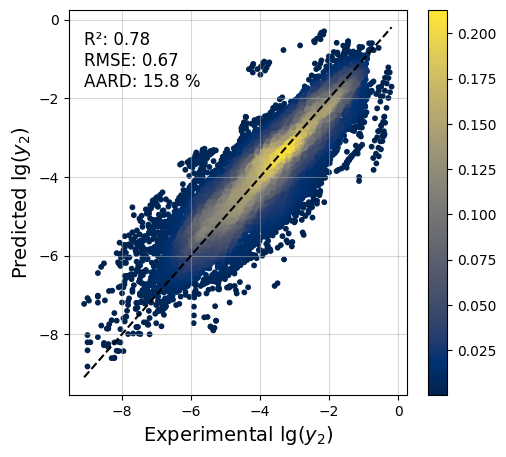

In [20]:
experimental = np.array(consens_df["experimental"])
predicted = np.array(consens_df["cons"])
errors = predicted - experimental

def calculate_aard(experimental, predicted):
    relative_errors = np.abs((experimental - predicted) / experimental)
    aard = np.mean(relative_errors) * 100 
    return aard

def scatter_density_plot(experimental, predicted):
    xy = np.vstack([experimental, predicted])
    z = gaussian_kde(xy)(xy)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    scatter = plt.scatter(experimental, predicted, c=z, s=10, cmap='cividis', alpha=1)
    plt.colorbar(scatter)
     
    plt.plot([min(experimental), max(experimental)], [min(experimental), max(experimental)], 'k--')

    plt.xlabel(r'Experimental $\mathrm{lg}(y_2)$', fontsize=14)
    plt.ylabel(r'Predicted $\mathrm{lg}(y_2)$', fontsize=14)
    plt.grid(True, alpha=0.5)

    rmse = np.sqrt(np.mean(errors**2))
    r_squared = np.corrcoef(experimental, predicted)[0, 1]**2
    aard = calculate_aard(experimental, predicted) 
    
    plt.text(min(experimental), max(predicted) - 1.4, f'R²: {r_squared:.2f}\nRMSE: {rmse:.2f} \nAARD: {aard:.1f} %', fontsize=12)


scatter_density_plot(experimental, predicted)